In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm

from modelbase.ode import Simulator
from scipy.integrate import trapezoid
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm
from modelbase.ode import mca


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses-paper/

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
m = get_model() #get model

In [7]:
#add new parameters with values from Dave Kramer 
m.add_parameter("b6f_content", 1)
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)

##forward rate constant, consisiting of pH depending component that pumps protons into lumen
##protonation rate, which depends on pH and multiplied with scaling parameter
def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

##because reaction is reversible forward rate constant/eq constant = reverse rate constant
#simple reaction rate, concentration substrates * forwards - concentration products - backwards
##!!!!!!!check whether it is necessary to keep PQ in fraction and not total number!!!!!!!
def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [8]:
m.add_parameter("ATPturnover", 90)


def ATP_gamma(Pi,ATP,ADP,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000))

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH) + RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)


In [9]:
### Light-induced chlorophyll (Chl) fluorescence induction kinetics (Kautsky effect) ###
def Fs_det (s:Simulator,adaption_pfd:float, adaption_time:float, measuring_pfd:float, measuring_time:float):
    time=[adaption_time, measuring_time+adaption_time]
    pfd=[adaption_pfd,measuring_pfd]    
    for t, light in zip(time, pfd):
        print(light)
        print(t)
        s.update_parameter("pfd", light)
        s.simulate(t)
    full_fluo=(s.get_full_results_df()["Fluo"]/max(s.get_full_results_df()["Fluo"]))
    Fs=(s.get_full_results_df()["Fluo"].iloc[-1]/max(s.get_full_results_df()["Fluo"]))
    Fo=(s.get_full_results_df()["Fluo"].iloc[0]/max(s.get_full_results_df()["Fluo"]))
    return full_fluo, Fs, Fo

In [10]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    adaption :float,
    time_adaption : float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    s.update_parameter("pfd", adaption)
    s.simulate(time_adaption)
    print("adaption done with:",str(time_adaption)+" and "+str(adaption))
    t = list(it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32))))
    for f in range(len(t)):
        t[f]= t[f] + time_adaption
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    qPSII = (Fm-Fo) / Fm
    return Fm, NPQ, qPSII ,tm, Fo, to

In [11]:
""" 
parameters=["k2", "kF", "kH", "kH0"]â
def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    return (ps2cs * kF * B0) / (kF + k2 + kH * Q) + (ps2cs * kF * B2) / (kF + kH * Q)
"""

' \nparameters=["k2", "kF", "kH", "kH0"]â\ndef fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):\n    return (ps2cs * kF * B0) / (kF + k2 + kH * Q) + (ps2cs * kF * B2) / (kF + kH * Q)\n'

simulation:   0%|          | 0/4 [00:00<?, ?it/s]

50
1200
4000
2200


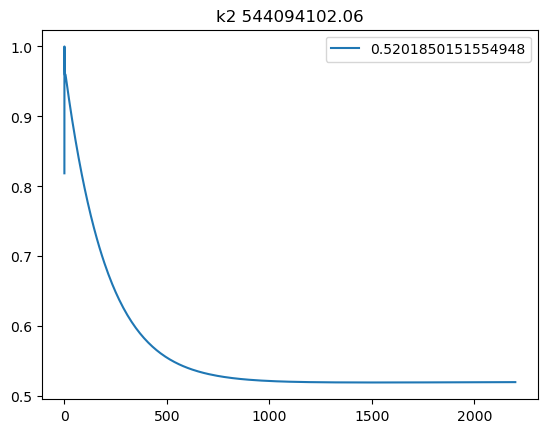

50
1200
4000
2200


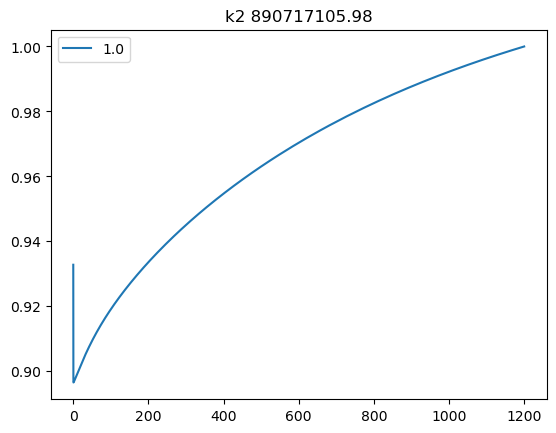

50
1200
4000
2200


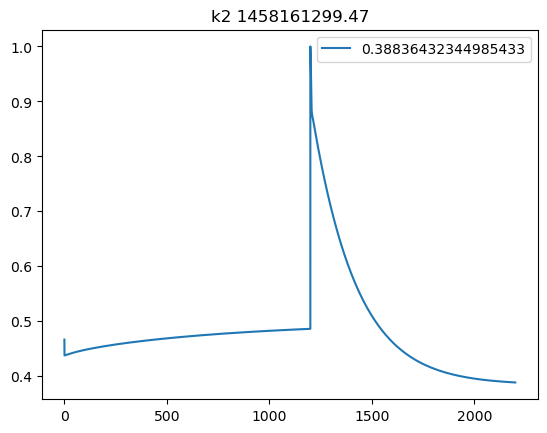

50
1200
4000
2200


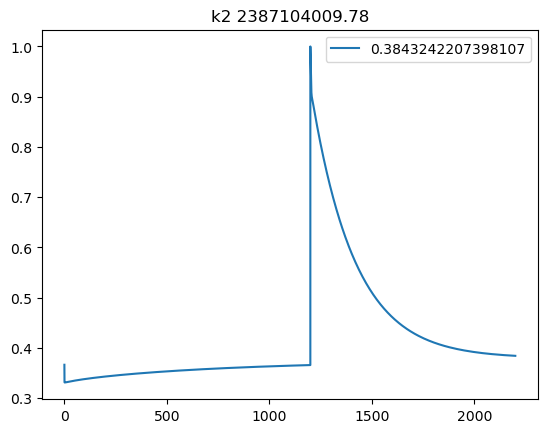

50
1200
4000
2200


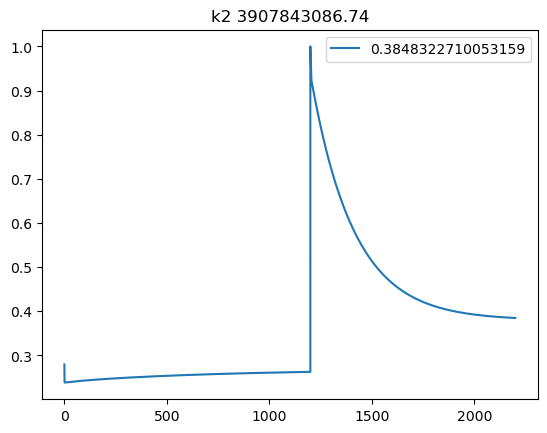

50
1200
4000
2200


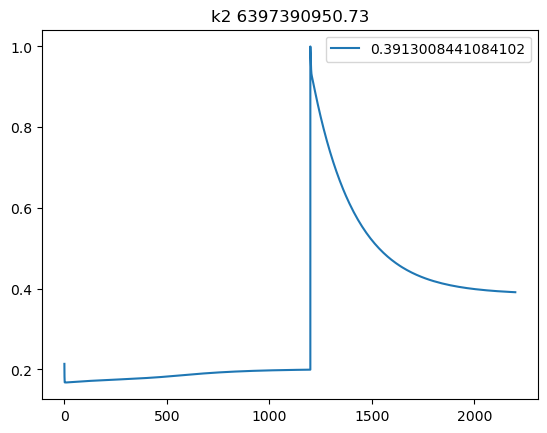

50
1200
4000
2200


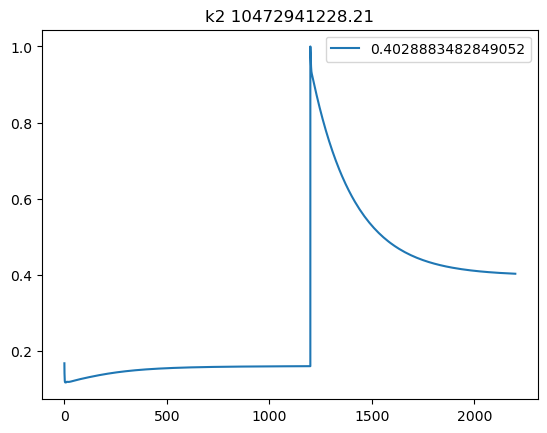

50
1200
4000
2200


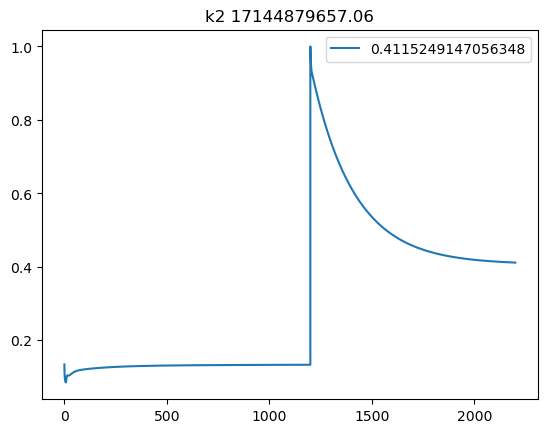

50
1200
4000
2200


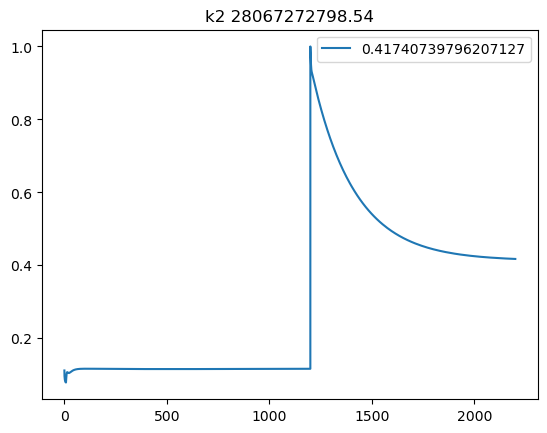

50
1200
4000
2200


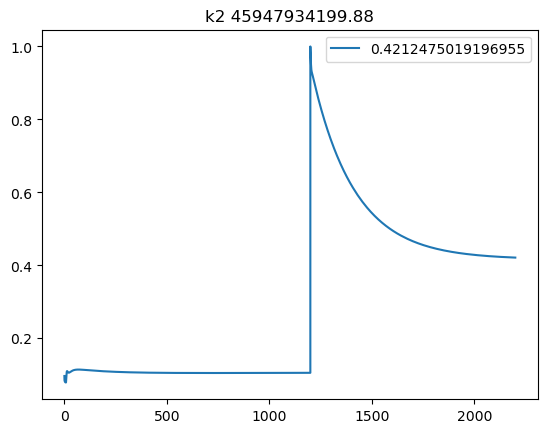

fully finished k2
50
1200
4000
2200


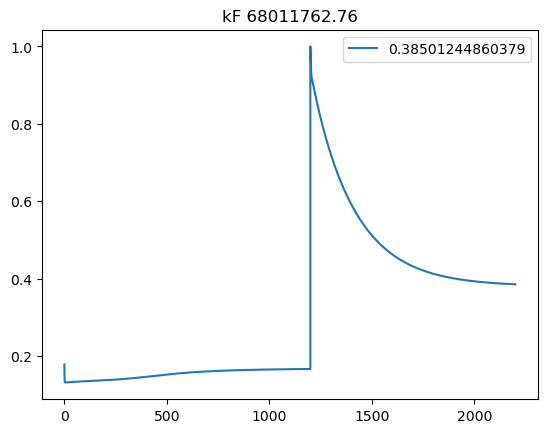

50
1200
4000
2200


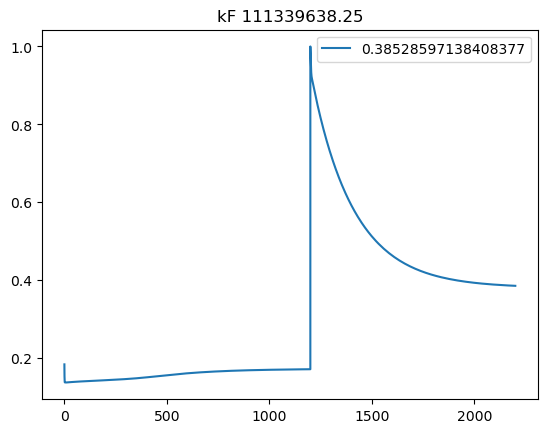

50
1200
4000
2200


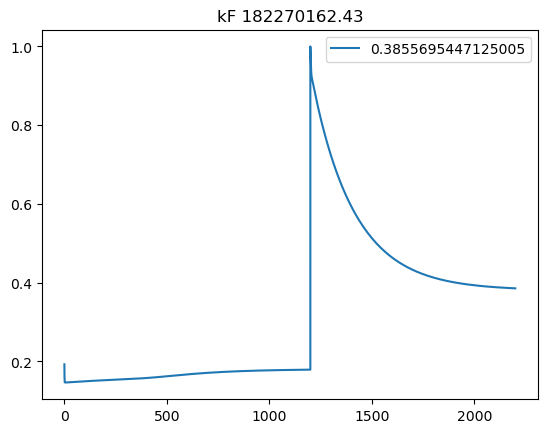

50
1200
4000
2200


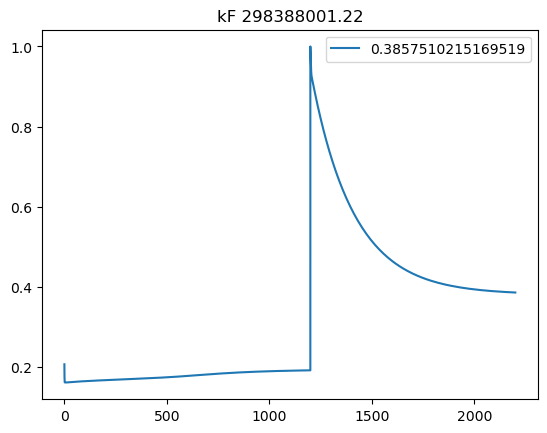

50
1200
4000
2200


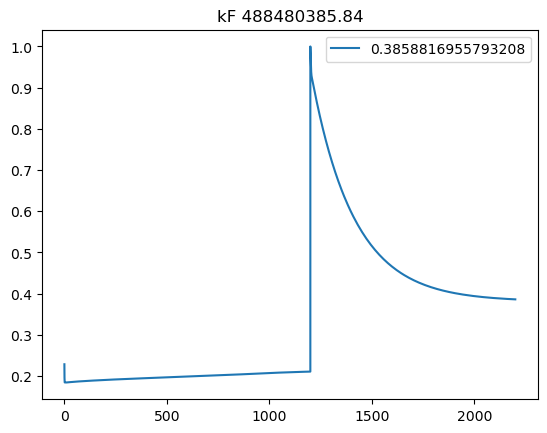

50
1200
4000
2200


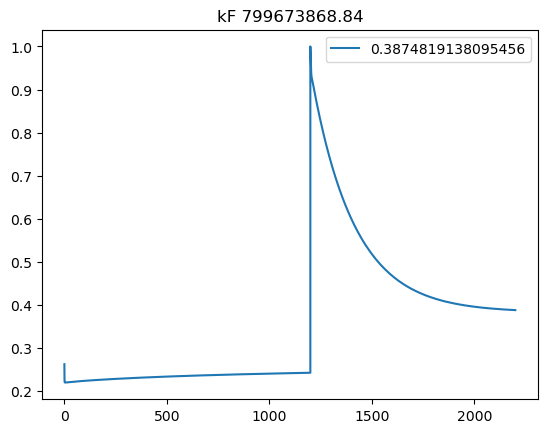

50
1200
4000
2200


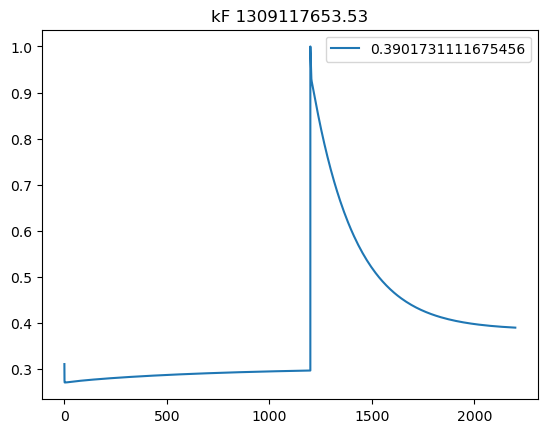

50
1200
4000
2200


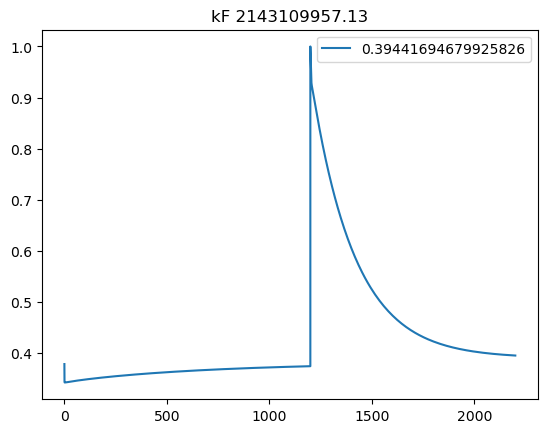

50
1200
4000
2200


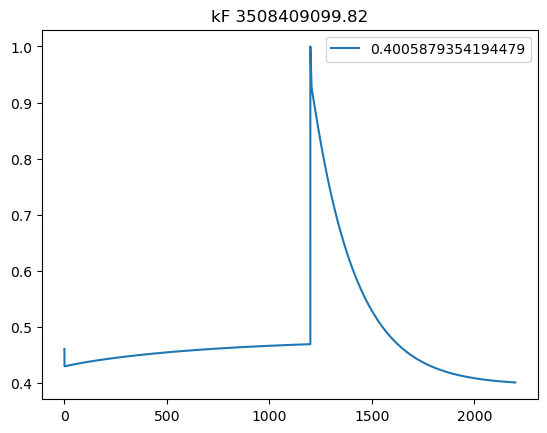

50
1200
4000
2200


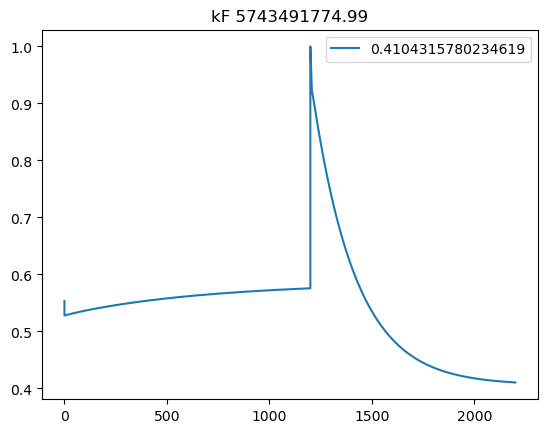

fully finished kF
50
1200
4000
2200


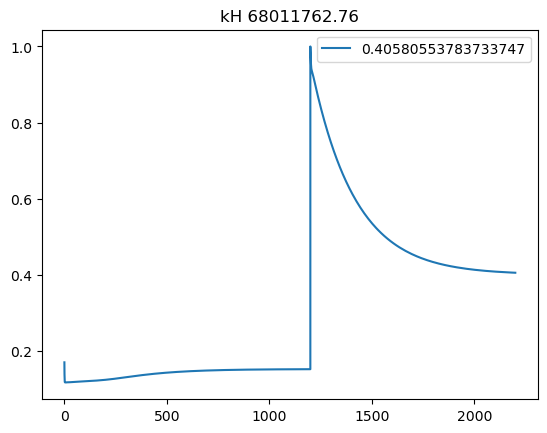

50
1200
4000
2200


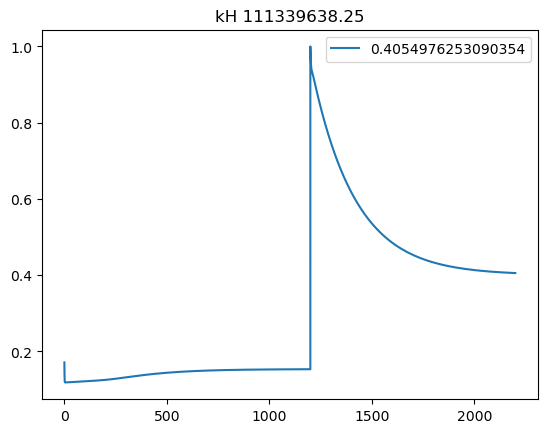

50
1200
4000
2200


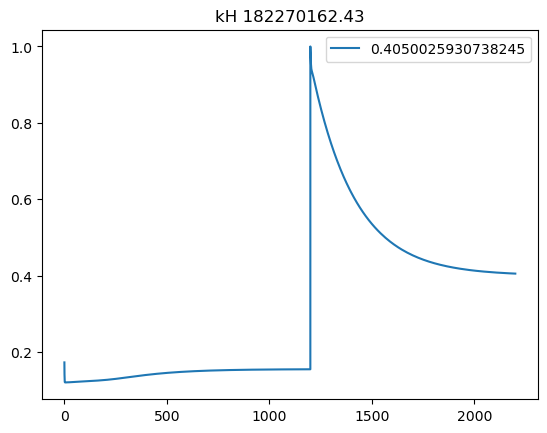

50
1200
4000
2200


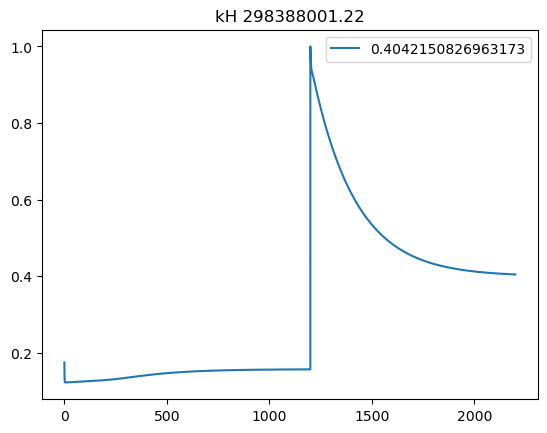

50
1200
4000
2200


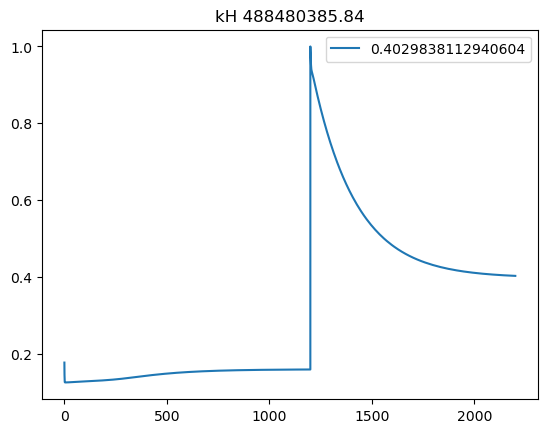

50
1200
4000
2200


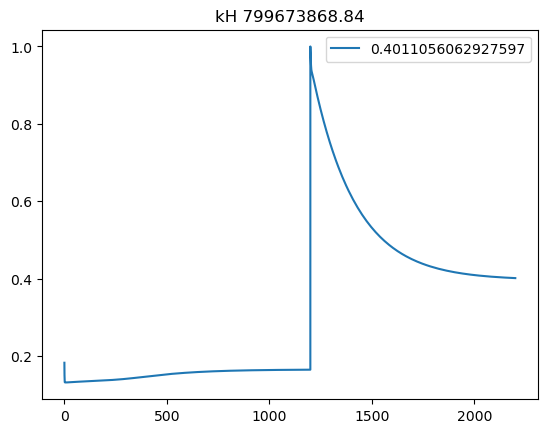

50
1200
4000
2200


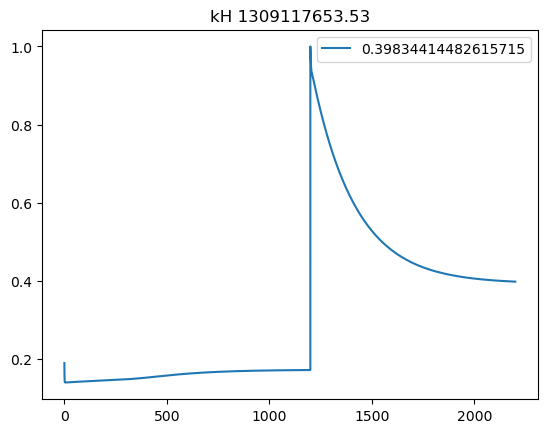

50
1200
4000
2200


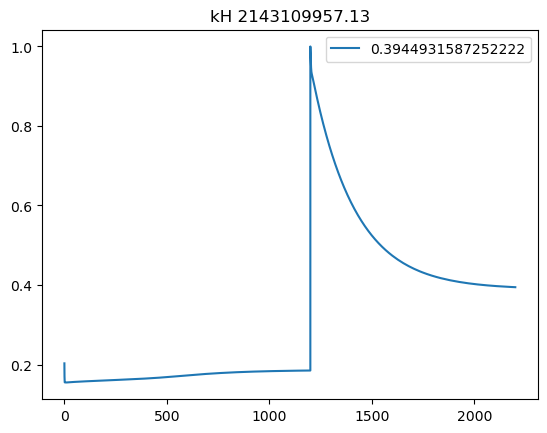

50
1200
4000
2200


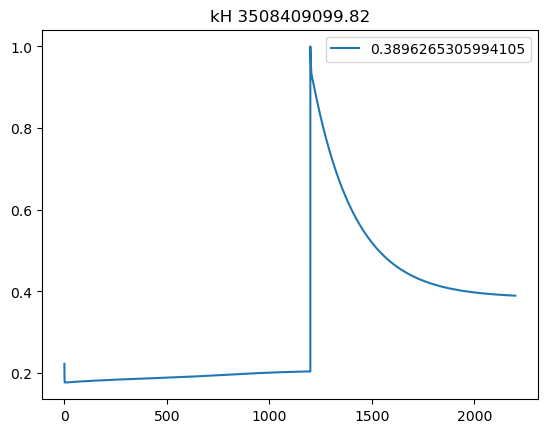

50
1200
4000
2200


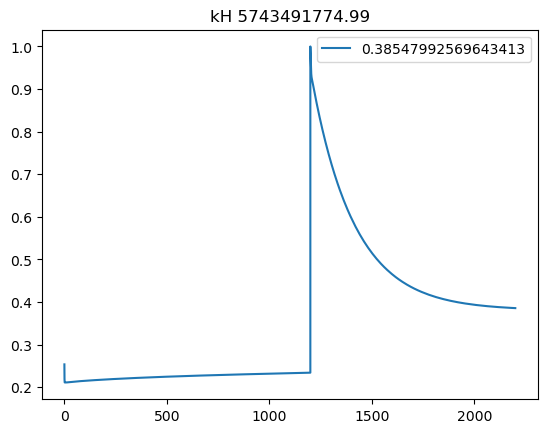

fully finished kH
50
1200
4000
2200


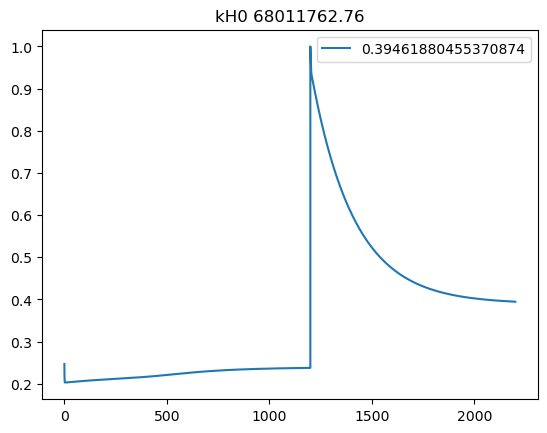

50
1200
4000
2200


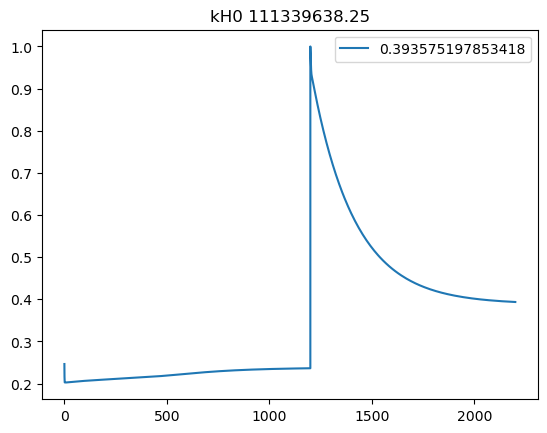

50
1200
4000
2200


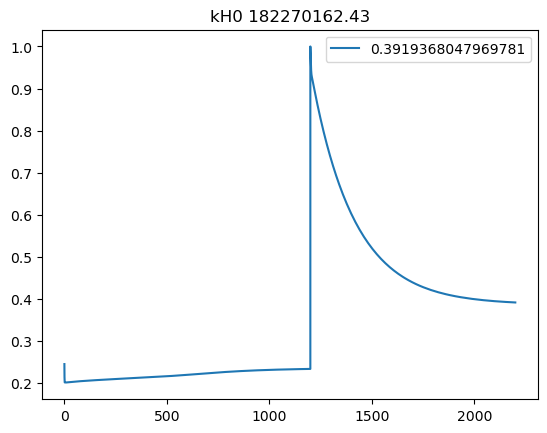

50
1200
4000
2200


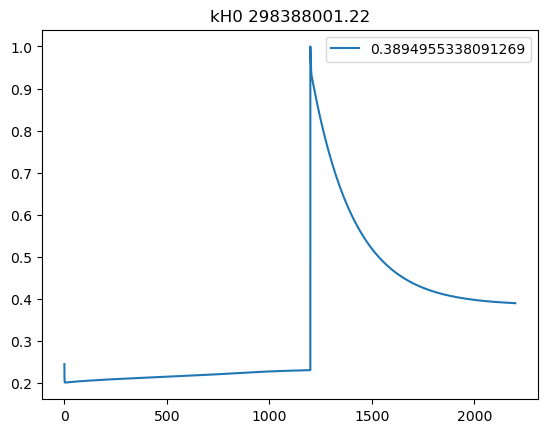

50
1200
4000
2200


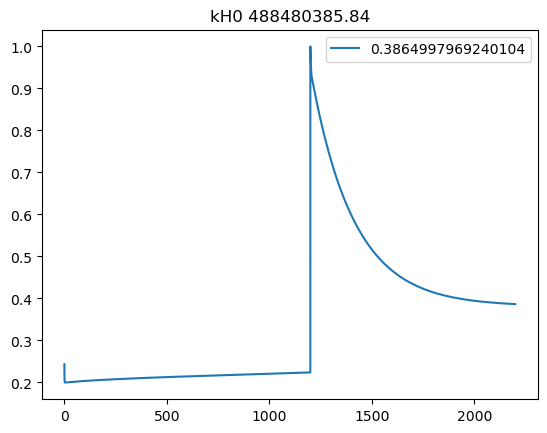

50
1200
4000
2200


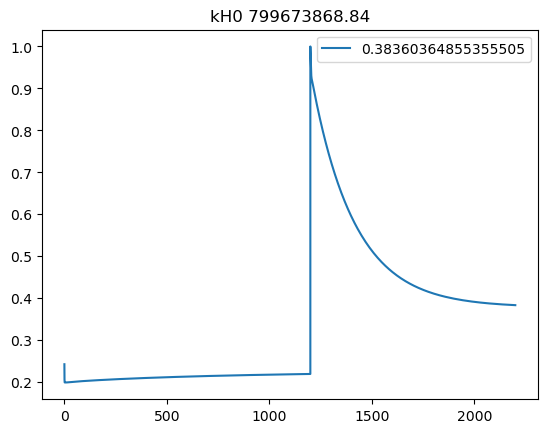

50
1200
4000
2200


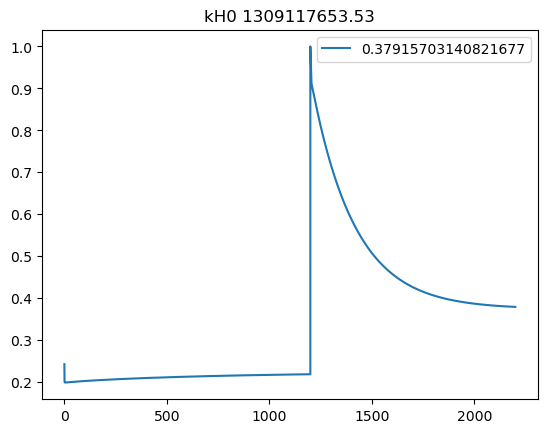

50
1200
4000
2200


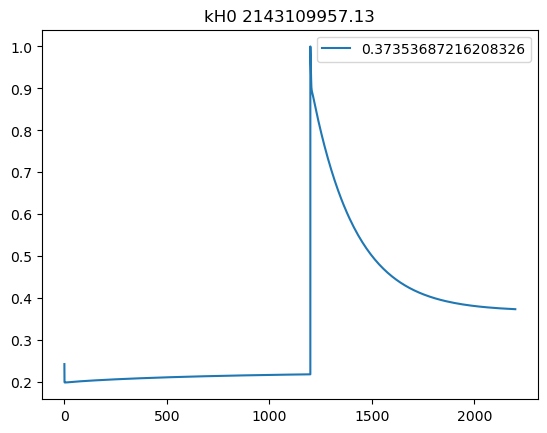

50
1200
4000
2200


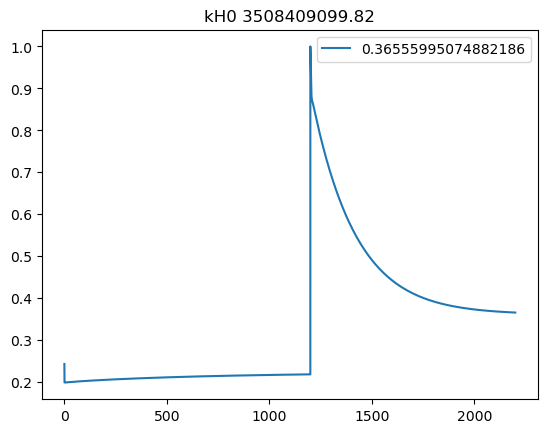

50
1200
4000
2200


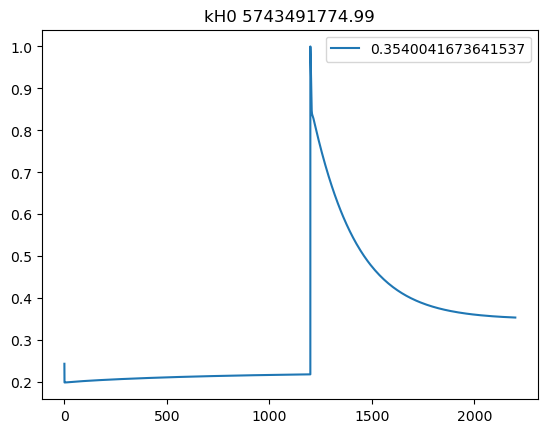

fully finished kH0


In [12]:
NUM_SCANS = 10
parameters=["k2", "kF", "kH", "kH0"]
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
k2_vals= m.parameters["k2"]*2**(log2)
kF_vals= m.parameters["kF"]*2**(log2)
kH_vals= m.parameters["kH"]*2**(log2)
kH0_vals= m.parameters["kH0"]*2**(log2)
log2_vals=[k2_vals,kF_vals,kH_vals,kH0_vals]
full_results=[]
Fs_results=[]
Fo_results=[]
k2_full_results=[]
k2_Fs=[]
k2_Fo=[]
kF_full_results=[]
kF_Fs=[]
kF_Fo=[]
kH_full_results=[]
kH_Fs=[]
kH_Fo=[]
kH0_full_results=[]
kH0_Fs=[]
kH0_Fo=[]
x=0
for i in tqdm(parameters, total=len(parameters), desc="simulation"):
    s1 = Simulator(m)
    s1.initialise(y0)
    s1.update_parameter("kH", 5e9)
    s1.update_parameter("kH0", 5e8)
    s1.update_parameter("kF", 6.25e8)
    s1.update_parameter("k2", 5e9)
    for j in log2_vals[x]:
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(i,j)
        s1.update_parameter("kcyc",0)
        full, Fs, Fo = Fs_det (s1, 50, 1200, 4000,1000)
        full_results.append(full)
        Fs_results.append(Fs)
        Fo_results.append(Fo)
        plt.plot(full, label=str(Fs))
        plt.title(i+" "+str(round(m.get_parameter(i),2)))
        plt.legend()
        plt.show()
    if i == "k2":
        k2_full_results.append(full_results)
        k2_Fs.append(Fs_results)
        k2_Fo.append(Fo_results)
    if i == "kF":
        kF_full_results.append(full_results)
        kF_Fs.append(Fs_results)
        kF_Fo.append(Fo_results)
    if i == "kH":
        kH_full_results.append(full_results)
        kH_Fs.append(Fs_results)
        kH_Fo.append(Fo_results)
    if i == "kH0":
        kH0_full_results.append(full_results)
        kH0_Fs.append(Fs_results)
        kH0_Fo.append(Fo_results)
    full_results=[]
    Fs_results=[]
    Fo_results=[] 
    x=+1
    print("fully finished", i)

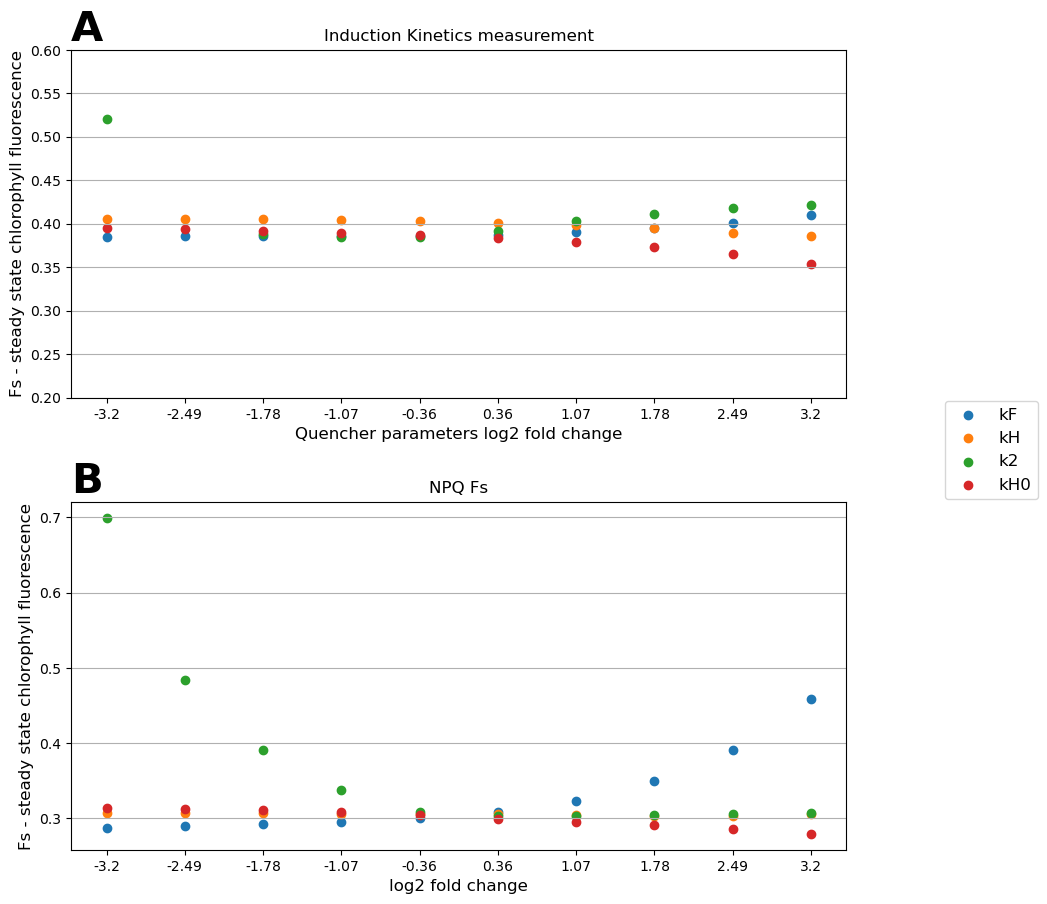

In [21]:
listis = []
for i in log2:
    listis.append(str(round(i,2)))

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
ax1.set_title("A" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax1.scatter(listis,kF_Fs, label="kF", )
ax1.scatter(listis,kH_Fs, label="kH",)
ax1.scatter(listis,k2_Fs, label="k2", )
ax1.scatter(listis,kH0_Fs, label="kH0", )
ax1.set_xlabel("log2 fold change", fontsize=12)
ax1.set_ylabel("Fs - steady state chlorophyll fluorescence", fontsize=12)
#ax1.legend()
ax1.grid(axis="y")
ax1.set(
    title="Induction Kinetics measurement",
    xlabel="Quencher parameters log2 fold change",
    ylabel="Fs - steady state chlorophyll fluorescence",
    ylim=(0.2,0.6)
)

ax2.set_title("B" , loc="left", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
ax2.scatter(listis,kF_Fs1 )
ax2.scatter(listis,kH_Fs1)
ax2.scatter(listis,k2_Fs1 )
ax2.scatter(listis,kH0_Fs1)
#ax2.legend()
ax2.set_title("NPQ Fs")
ax2.set_xlabel("log2 fold change", fontsize=12)
ax2.set_ylabel("Fs - steady state chlorophyll fluorescence", fontsize=12)
ax2.grid(axis="y")
#ax2.set(
#    xlabel="Quencher parameters log2 fold change",
#    ylabel="NPQ/s",)
fig.legend(loc="center right",  bbox_to_anchor=(1.1, 0.5), fontsize=12)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)

In [53]:
s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc",0)
s1.update_parameter("kH0",5e9)
s1.update_parameter("k2",5e9)
full, Fs, Fo = Fs_det (s1, 50, 1200, 4000,1000)

50
1200
4000
2200


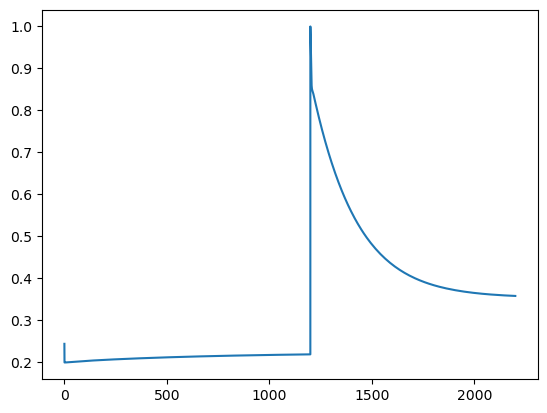

In [54]:
plt.plot(full)

In [ ]:
#leave k2 untoueched
#kF lower for lower Fs
#kH higher for lower Fs
#kH0 higher fo lower Fs

In [14]:
def get_Fs(s:Simulator, start:float, end: float) -> Tuple[int, int, np.array]:
    c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][start:end])/max(c["Fluo"])
    for i in range(20,len(g)):
        if i == (len(g)-4):
            ss = g.iloc[-4]
            print("finished with Fs:", ss, "at i:",i)
            break
        ssc=g.iloc[i]
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            print("finished with Fs:", ss, "at i:",i)
            break
    return ss, i, g


In [15]:
NUM_SCANS = 10
parameters=["k2", "kF", "kH", "kH0"]
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
log2 = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
k2_vals= m.parameters["k2"]*2**(log2)
kF_vals= m.parameters["kF"]*2**(log2)
kH_vals= m.parameters["kH"]*2**(log2)
kH0_vals= m.parameters["kH0"]*2**(log2)
log2_vals=[k2_vals,kF_vals,kH_vals,kH0_vals]
Fs_results1=[]
k2_Fs1=[]
kF_Fs1=[]
kH_Fs1=[]
kH0_Fs1=[]
x=0
for i in tqdm(parameters, total=len(parameters), desc="simulation"):
    s1 = Simulator(m)
    s1.initialise(y0)
    s1.update_parameter("kH", 5e9)
    s1.update_parameter("kH0", 5e8)
    s1.update_parameter("kF", 6.25e8)
    s1.update_parameter("k2", 5e9)
    for j in log2_vals[x]:
        s1 = Simulator(m)
        s1.initialise(y0)
        s1.update_parameter(i,j)
        s1.update_parameter("kcyc",0)
        pam_analysis(s1,
            t_relax=120,
            t_pulse=0.8,
            pfd_dark=50,
            pfd_illumination=1000,
            pfd_pulse=5000,
            adaption=1,
            time_adaption=10000)
        Fs,b,g = get_Fs(s1, 11330,11440)
        Fs_results1.append(Fs)
    if i == "k2":
        k2_Fs1.append(Fs_results1)
    if i == "kF":
        kF_Fs1.append(Fs_results1)
    if i == "kH":
        kH_Fs1.append(Fs_results1)
    if i == "kH0":
        kH0_Fs1.append(Fs_results1)
    Fs_results1=[]
    x=+1
    print("fully finished", i)

simulation:   0%|          | 0/4 [00:00<?, ?it/s]

adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.6996278242383096 at i: 68
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.48453690274450983 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3908053837397604 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.33772075332008206 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3092121630744617 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30314055210843094 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30338415537156294 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3050467555256971 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3061500531860518 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30750544994321005 at i: 20
fully finished k2
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.28778971326355135 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.2896183106359749 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.2921656120259484 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.29591261263121427 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3010710776444141 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3085837237357112 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3229521173541668 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3491044236014617 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3908876961197409 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.458423504571176 at i: 20
fully finished kF
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30665369567265244 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3069058831627674 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3068481069158673 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3065550087415366 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30602409662776925 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30547912284972767 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3047324209434477 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3036942969849666 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3037011946109786 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3053079633254336 at i: 20
fully finished kH
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.31394496076447903 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3128657175089163 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3113203928895686 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.3087012596490133 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.30485045991069987 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.29930358679165303 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.29504673713042845 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.2909087267604238 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.2854725225228945 at i: 20
adaption done with: 10000 and 1


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished with Fs: 0.27944122095292684 at i: 20
fully finished kH0
